In [4]:
import os
import torch

os.environ["TORCH"] = torch.__version__
print(torch.__version__)

1.12.1


In [5]:
import torch
torch.cuda.empty_cache()

In [6]:
!nvidia-smi

Mon Nov 28 10:04:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 497.29       Driver Version: 497.29       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8     1W /  N/A |    134MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# import required modules
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import copy
import argparse
from sklearn.metrics import roc_auc_score, f1_score

import torch
from torch import optim
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn import GCNConv


In [8]:
data_path = "./data/"
# data_path = '/content/drive/MyDrive/AI_Naver_PTIT/KGCN/torch/data/'


class DataLoader:
    """
    Data Loader class which makes dataset for training / knowledge graph dictionary
    """

    def __init__(self, data):
        self.cfg = {
            "movie": {
                "item2id_path": data_path + "movie/item_index2entity_id.txt",
                "kg_path": data_path + "movie/kg.txt",
                "rating_path": data_path + "movie/ratings.csv",
                "rating_sep": ",",
                "threshold": 4.0,
            },
            "music": {
                "item2id_path": data_path + "music/item_index2entity_id.txt",
                "kg_path": data_path + "music/kg.txt",
                "rating_path": data_path + "music/user_artists.dat",
                "rating_sep": "\t",
                "threshold": 0.0,
            },
            'kkbox': {
                'item2id_path': data_path + "KKBOX_data/item_index2entity_id.txt",
                'kg_path': data_path + "KKBOX_data/kg.txt",
                'rating_path': data_path + "KKBOX_data/user_item.dat",
                'rating_sep': '\t',
                'threshold': 0.0
            },
            'ml100k': {
                'item2id_path': data_path + "ML100K/item_index2entity_id.txt",
                'kg_path': data_path + "ML100K/kg.txt",
                'rating_path': data_path + "ML100K/user_item.dat",
                'rating_sep': '\t',
                'threshold': 0.0
            },
            'bookcrossing': {
                'item2id_path': data_path + 'BookCrossing/item_index2entity_id.txt',
                'kg_path': data_path + 'BookCrossing/kg.txt',
                'rating_path': data_path + 'BookCrossing/user_item.dat',
                'rating_sep': '\t',
                'threshold': 0.0
            },
            'ml1m': {
                'item2id_path': data_path + 'ML1M/item_index2entity_id.txt',
                'kg_path': data_path + 'ML1M/kg.txt',
                'rating_path': data_path + 'ML1M/user_item.dat',
                'rating_sep': '\t',
                'threshold': 4.0
            }
        }
        self.data = data

        df_item2id = pd.read_csv(
            self.cfg[data]["item2id_path"], sep="\t", header=None, names=["item", "id"]
        )
        df_kg = pd.read_csv(
            self.cfg[data]["kg_path"],
            sep="\t",
            header=None,
            names=["head", "relation", "tail"],
        )
        df_rating = pd.read_csv(
            self.cfg[data]["rating_path"],
            sep=self.cfg[data]["rating_sep"],
            names=["userID", "itemID", "rating"],
            skiprows=1,
        )

        # df_rating['itemID'] and df_item2id['item'] both represents old entity ID
        df_rating = df_rating[df_rating["itemID"].isin(df_item2id["item"])]
        df_rating.reset_index(inplace=True, drop=True)

        self.df_item2id = df_item2id
        self.df_kg = df_kg
        self.df_rating = df_rating

        self.user_encoder = LabelEncoder()
        self.entity_encoder = LabelEncoder()
        self.relation_encoder = LabelEncoder()

        self._encoding()

    def _encoding(self):
        """
        Fit each label encoder and encode knowledge graph
        """
        self.user_encoder.fit(self.df_rating["userID"])
        # df_item2id['id'] and df_kg[['head', 'tail']] represents new entity ID
        self.entity_encoder.fit(
            pd.concat([self.df_item2id["id"], self.df_kg["head"], self.df_kg["tail"]])
        )
        self.relation_encoder.fit(self.df_kg["relation"])

        # encode df_kg
        self.df_kg["head"] = self.entity_encoder.transform(self.df_kg["head"])
        self.df_kg["tail"] = self.entity_encoder.transform(self.df_kg["tail"])
        self.df_kg["relation"] = self.relation_encoder.transform(self.df_kg["relation"])

    def _build_dataset(self):
        """
        Build dataset for training (rating data)
        It contains negative sampling process
        """
        print("Build dataset dataframe ...", end=" ")
        # df_rating update
        df_dataset = pd.DataFrame()
        df_dataset["userID"] = self.user_encoder.transform(self.df_rating["userID"])

        # update to new id
        item2id_dict = dict(zip(self.df_item2id["item"], self.df_item2id["id"]))
        self.df_rating["itemID"] = self.df_rating["itemID"].apply(
            lambda x: item2id_dict[x]
        )
        df_dataset["itemID"] = self.entity_encoder.transform(self.df_rating["itemID"])
        df_dataset["label"] = self.df_rating["rating"].apply(
            lambda x: 0 if x < self.cfg[self.data]["threshold"] else 1
        )

        # negative sampling
        df_dataset = df_dataset[df_dataset["label"] == 1]
        # df_dataset requires columns to have new entity ID
        full_item_set = set(range(len(self.entity_encoder.classes_)))
        user_list = []
        item_list = []
        label_list = []
        for user, group in df_dataset.groupby(["userID"]):
            item_set = set(group["itemID"])
            negative_set = full_item_set - item_set
            negative_sampled = random.sample(negative_set, len(item_set))
            user_list.extend([user] * len(negative_sampled))
            item_list.extend(negative_sampled)
            label_list.extend([0] * len(negative_sampled))
        negative = pd.DataFrame(
            {"userID": user_list, "itemID": item_list, "label": label_list}
        )
        df_dataset = pd.concat([df_dataset, negative])

        df_dataset = df_dataset.sample(frac=1, replace=False, random_state=999)
        df_dataset.reset_index(inplace=True, drop=True)
        print("Done")
        return df_dataset

    def _construct_kg(self):
        """
        Construct knowledge graph
        Knowledge graph is dictionary form
        'head': [(relation, tail), ...]
        """
        print("Construct knowledge graph ...", end=" ")
        kg = dict()
        for i in range(len(self.df_kg)):
            head = self.df_kg.iloc[i]["head"]
            relation = self.df_kg.iloc[i]["relation"]
            tail = self.df_kg.iloc[i]["tail"]
            if head in kg:
                kg[head].append((relation, tail))
            else:
                kg[head] = [(relation, tail)]
            if tail in kg:
                kg[tail].append((relation, head))
            else:
                kg[tail] = [(relation, head)]
        print("Done")
        return kg

    def load_dataset(self):
        return self._build_dataset()

    def load_kg(self):
        return self._construct_kg()

    def get_encoders(self):
        return (self.user_encoder, self.entity_encoder, self.relation_encoder)

    def get_num(self):
        return (
            len(self.user_encoder.classes_),
            len(self.entity_encoder.classes_),
            len(self.relation_encoder.classes_),
        )

In [9]:
# parser = argparse.ArgumentParser()

# parser.add_argument("--dataset", type=str, default="music", help="which dataset to use")
# parser.add_argument("--n_epochs", type=int, default=25, help="the number of epochs")
# parser.add_argument(
#     "--dim", type=int, default=16, help="dimension of user and entity embeddings"
# )
# parser.add_argument("--batch_size", type=int, default=32, help="batch size")
# parser.add_argument(
#     "--l2_weight", type=float, default=1e-4, help="weight of l2 regularization"
# )
# parser.add_argument("--lr", type=float, default=5e-4, help="learning rate")
# parser.add_argument("--ratio", type=float, default=0.6, help="size of training dataset")

# args = parser.parse_args([])

In [10]:
# parser = argparse.ArgumentParser()

# parser.add_argument('--dataset', type=str, default='movie', help='which dataset to use')
# parser.add_argument('--n_epochs', type=int, default=2, help='the number of epochs')
# parser.add_argument('--dim', type=int, default=32, help='dimension of user and entity embeddings')
# parser.add_argument('--batch_size', type=int, default=65536, help='batch size')
# parser.add_argument('--l2_weight', type=float, default=1e-7, help='weight of l2 regularization')
# parser.add_argument('--lr', type=float, default=2e-2, help='learning rate')
# parser.add_argument('--ratio', type=float, default=0.6, help='size of training dataset')

# args = parser.parse_args([])

In [11]:
# parser = argparse.ArgumentParser()

# parser.add_argument('--dataset', type=str, default='kkbox', help='which dataset to use')
# parser.add_argument('--n_epochs', type=int, default=100, help='the number of epochs')
# parser.add_argument('--dim', type=int, default=32, help='dimension of user and entity embeddings')
# parser.add_argument('--batch_size', type=int, default=32768, help='batch size')
# parser.add_argument('--l2_weight', type=float, default=1e-7, help='weight of l2 regularization')
# parser.add_argument('--lr', type=float, default=2e-2, help='learning rate')
# parser.add_argument('--ratio', type=float, default=0.6, help='size of training dataset')

# args = parser.parse_args([])

In [12]:
parser = argparse.ArgumentParser()

parser.add_argument('--dataset', type=str, default='ml100k', help='which dataset to use')
parser.add_argument('--n_epochs', type=int, default=100, help='the number of epochs')
parser.add_argument('--dim', type=int, default=128, help='dimension of user and entity embeddings')
parser.add_argument('--batch_size', type=int, default=16, help='batch size')
parser.add_argument('--l2_weight', type=float, default=1e-4, help='weight of l2 regularization')
parser.add_argument('--lr', type=float, default=5e-4, help='learning rate')
parser.add_argument('--ratio', type=float, default=0.6, help='size of training dataset')

args = parser.parse_args([])

In [13]:
# parser = argparse.ArgumentParser()

# parser.add_argument('--dataset', type=str, default='bookcrossing', help='which dataset to use')
# parser.add_argument('--n_epochs', type=int, default=100, help='the number of epochs')
# parser.add_argument('--dim', type=int, default=32, help='dimension of user and entity embeddings')
# parser.add_argument('--batch_size', type=int, default=128, help='batch size')
# parser.add_argument('--l2_weight', type=float, default=1e-4, help='weight of l2 regularization')
# parser.add_argument('--lr', type=float, default=5e-4, help='learning rate')
# parser.add_argument('--ratio', type=float, default=0.6, help='size of training dataset')

# args = parser.parse_args([])

In [14]:
# parser = argparse.ArgumentParser()

# parser.add_argument('--dataset', type=str, default='ml1m', help='which dataset to use')
# parser.add_argument('--n_epochs', type=int, default=100, help='the number of epochs')
# parser.add_argument('--dim', type=int, default=32, help='dimension of user and entity embeddings')
# parser.add_argument('--batch_size', type=int, default=2048, help='batch size')
# parser.add_argument('--l2_weight', type=float, default=1e-7, help='weight of l2 regularization')
# parser.add_argument('--lr', type=float, default=2e-2, help='learning rate')
# parser.add_argument('--ratio', type=float, default=0.6, help='size of training dataset')

# args = parser.parse_args([])

In [15]:
# build dataset and knowledge graph
data_loader = DataLoader(args.dataset)
kg = data_loader.load_kg()
df_dataset = data_loader.load_dataset()
df_dataset

Construct knowledge graph ... Done
Build dataset dataframe ... Done


,userID,itemID,label
0,124,5660,0
1,681,2465,0
2,346,5947,0
3,404,662,1
4,270,646,1
...,...,...,...
199943,192,1,1
199944,384,6607,0
199945,337,5808,0
199946,534,204,1


In [16]:
# Dataset class
class KGCNDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user_id = np.array(self.df.iloc[idx]["userID"])
        item_id = np.array(self.df.iloc[idx]["itemID"])
        label = np.array(self.df.iloc[idx]["label"], dtype=np.float32)
        return user_id, item_id, label

In [17]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(
    df_dataset,
    df_dataset["label"],
    test_size=1 - args.ratio,
    shuffle=False,
    random_state=999,
)
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, test_size=0.05, shuffle=False, random_state=999
)
train_dataset = KGCNDataset(x_train)
val_dataset = KGCNDataset(x_val)
test_dataset = KGCNDataset(x_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=args.batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_dataset.__len__())

test_loader_batch = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size)

In [27]:
# import sys
# import torch
# import torch.nn.functional as F
# import random
# import numpy as np
# import copy
# from torch_geometric.utils import add_self_loops, degree
# from torch.nn import Linear, Parameter


# class vanilla_gcn(MessagePassing):
#     def __init__(self, num_user, num_ent, num_rel, kg, args, device):
#         super(vanilla_gcn, self).__init__(aggr="add")
#         self.num_user = num_user
#         self.num_ent = num_ent
#         self.num_rel = num_rel
#         self.batch_size = args.batch_size
#         self.dim = args.dim
#         self.max_neighbor = 20
#         self.kg = kg
#         self.device = device

#         self._gen_adj()

#         self.usr = torch.nn.Embedding(num_user, args.dim)
#         self.ent = torch.nn.Embedding(num_ent, args.dim)

#         self.lin = Linear(self.dim, self.dim, bias=False)
#         self.bias = Parameter(torch.Tensor(self.dim))

#         self.reset_parameters()

#     def reset_parameters(self):
#         self.lin.reset_parameters()
#         self.bias.data.zero_()

#     def _gen_adj(self):
#         src = []
#         target = []
#         for e in self.kg:
#             if len(self.kg[e]) >= self.max_neighbor:
#                 neighbors_filter = random.sample(
#                     self.kg[e], self.max_neighbor
#                 )
#             else:
#                 neighbors_filter = self.kg[e]
#             for n in neighbors_filter:
#                 src.append(e)
#                 target.append(n[1])
#         self.edge_index = torch.tensor([src, target], dtype=torch.long)

#     def forward(self, user_indices, item_indices, device):

#         # Step 1: Add self-loops to the adjacency matrix.
#         edge_index = self.edge_index
#         edge_index = edge_index.to(device)

#         # Step 2: Linearly transform node feature matrix.
#         x = self.lin(self.ent.weight)

#         # Step 3: Compute normalization.
#         row, col = edge_index
#         deg = degree(col, x.size(0), dtype=x.dtype)
#         deg_inv_sqrt = deg.pow(-0.5)
#         deg_inv_sqrt[deg_inv_sqrt == float("inf")] = 0
#         norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

#         # Step 4-5: Start propagating messages.
#         item_embs_all = self.propagate(edge_index, x=x, norm=norm)

#         # Step 6: Apply a final bias vector.
#         item_embs_all += self.bias

#         user_embeddings = self.usr(user_indices)

#         item_embs = item_embs_all[item_indices]

#         scores = (item_embs * user_embeddings).sum(dim=-1)

#         return torch.sigmoid(scores)

#     def message(self, x_j, norm):
#         # x_j has shape [E, out_channels]

#         # Step 4: Normalize node features.
#         return norm.view(-1, 1) * x_j

In [18]:
import torch
import random
import numpy as np
import copy
from torch_geometric.nn import GCNConv


class vanilla_gcn(torch.nn.Module):
    def __init__(self, num_user, num_ent, num_rel, kg, args, device):
        super().__init__()
        self.num_user = num_user
        self.num_ent = num_ent
        self.num_rel = num_rel
        self.batch_size = args.batch_size
        self.dim = args.dim
        self.max_neighbor = 20
        self.kg = kg
        self.device = device
        self._gen_adj()
        self.usr = torch.nn.Embedding(num_user, args.dim)
        self.ent = torch.nn.Embedding(num_ent, args.dim)
        self.gcnConv = GCNConv(args.dim, args.dim, cached=True, normalize=True, bias=True)

    def _gen_adj(self):
        src = []
        target = []
        for e in self.kg:
            if len(self.kg[e]) >= self.max_neighbor:
                neighbors_filter = random.sample(
                    self.kg[e], self.max_neighbor
                )
            else:
                neighbors_filter = self.kg[e]
            for n in neighbors_filter:
                src.append(e)
                target.append(n[1])
        self.edge_index = torch.tensor([src, target], dtype=torch.long).to(self.device)

    def forward(self, user_indices, item_indices, device):
        x = self.gcnConv(x=self.ent.weight, edge_index=self.edge_index)
        user_embeddings = self.usr(user_indices)
        item_embs = x[item_indices]
        scores = (item_embs * user_embeddings).sum(dim=-1)
        return torch.sigmoid(scores)

## train

In [19]:
# prepare network, loss function, optimizer
num_user, num_entity, num_relation = data_loader.get_num()
user_encoder, entity_encoder, relation_encoder = data_loader.get_encoders()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = vanilla_gcn_2(num_user, num_entity, num_relation, kg, args, device).to(device)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2_weight)
print("device: ", device)

device:  cuda


In [21]:
name_version = "vanilla_gcn"
patience = 5

In [22]:
from pytorchtools import EarlyStopping
# add early stopping
early_stopping = EarlyStopping(patience=patience, verbose=True, path=f'./checkpoint/{name_version}_{args.dataset}.pt', delta=0.005)
# early_stopping = EarlyStopping(patience=patience, verbose=True, path=f'./checkpoint/{name_version}_{args.dataset}.pt')

# train
loss_list = []

val_loss_list = []
val_auc_score_list = []
val_f1_score_list = []

import time

start_train = time.time()
print("start_train:", start_train)


for epoch in range(args.n_epochs):
    running_loss = 0.0

    for i, (user_ids, item_ids, labels) in enumerate(train_loader):
        user_ids, item_ids, labels = (
            user_ids.to(device),
            item_ids.to(device),
            labels.to(device),
        )
        optimizer.zero_grad()
        outputs = net(user_ids, item_ids, device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # print train loss per every epoch
    print("[Epoch {}]".format(epoch + 1))
    print("train_loss: ".format(epoch + 1), running_loss / len(train_loader))
    loss_list.append(running_loss / len(train_loader))

    # evaluate per every epoch
    with torch.no_grad():
        val_loss = 0
        val_total_roc = 0
        val_total_f1 = 0
        for user_ids, item_ids, labels in val_loader:
            user_ids, item_ids, labels = (
                user_ids.to(device),
                item_ids.to(device),
                labels.to(device),
            )
            outputs = net(user_ids, item_ids, device)
            val_loss += criterion(outputs, labels).item()
            outputs = outputs.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            val_total_roc += roc_auc_score(labels, outputs)
            outputs = np.where(outputs >= 0.5, 1, 0)
            val_total_f1 += f1_score(labels, outputs)

        print("val_loss: ".format(epoch + 1), val_loss / len(val_loader))
        print("val_auc: ".format(epoch + 1), val_total_roc / len(val_loader))
        print("val_f1: ".format(epoch + 1), val_total_f1 / len(val_loader))
        # print("--------------------------------")
        val_loss_list.append(val_loss / len(val_loader))
        val_auc_score_list.append(val_total_roc / len(val_loader))
        val_f1_score_list.append(val_total_f1 / len(val_loader))

    # early stopping
    early_stopping(val_loss / len(val_loader), net)
    if early_stopping.early_stop:
        print("Early stopping")
        break

end_train = time.time()
print("end_train:", end_train)
print("end_train - start_train:", end_train - start_train)

pytorch tools loaded
start_train: 1669604688.4159572
[Epoch 1]
train_loss:  1.3034133196063886
val_loss:  0.7490735050188062
val_auc:  0.5944771725607176
val_f1:  0.5586490996622238
Validation loss decreased (inf --> 0.749074).  Saving model ...
[Epoch 2]
train_loss:  0.4243471055247126
val_loss:  0.2876364891004515
val_auc:  0.9500438989778729
val_f1:  0.8971381043470634
Validation loss decreased (0.749074 --> 0.287636).  Saving model ...
[Epoch 3]
train_loss:  0.2553358589105008
val_loss:  0.25725442229145123
val_auc:  0.9558882557599279
val_f1:  0.9046033412966904
Validation loss decreased (0.287636 --> 0.257254).  Saving model ...
[Epoch 4]
train_loss:  0.24399784833906285
val_loss:  0.25037589518851067
val_auc:  0.9571845190705647
val_f1:  0.9061264530766959
Validation loss decreased (0.257254 --> 0.250376).  Saving model ...
[Epoch 5]
train_loss:  0.23924618414693846
val_loss:  0.24675339226806872
val_auc:  0.9579640487726299
val_f1:  0.9072923946199609
EarlyStopping counter: 1 o

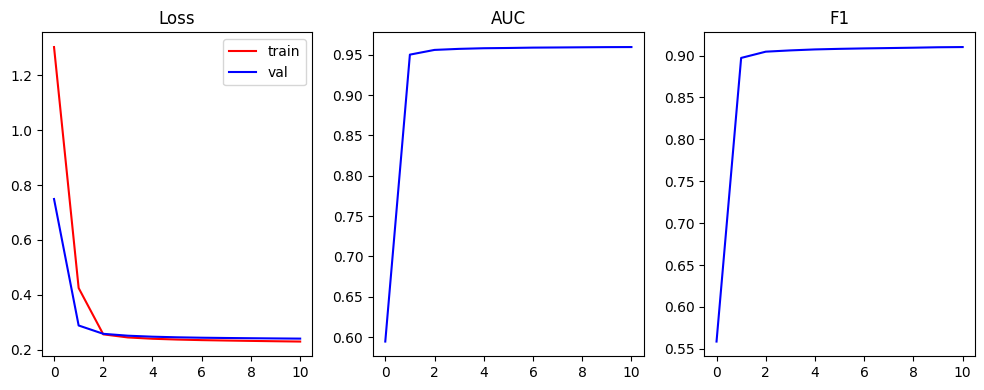

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
ax1.plot(loss_list, color='red')
ax1.plot(val_loss_list, color='blue')
ax1.set_title("Loss")
ax1.legend(['train', 'val'])
ax2.plot(val_auc_score_list, color='blue')
ax2.set_title("AUC")
ax3.plot(val_f1_score_list, color='blue')
ax3.set_title("F1")

plt.tight_layout()

In [24]:
# load the last checkpoint with the best model
net = vanilla_gcn(num_user, num_entity, num_relation, kg, args, device).to(device)
net.load_state_dict(torch.load(f'./checkpoint/{name_version}_{args.dataset}.pt'))

# test
with torch.no_grad():
    total_roc = 0
    total_f1 = 0
    for user_ids, item_ids, labels in test_loader:
        user_ids, item_ids, labels = (
            user_ids.to(device),
            item_ids.to(device),
            labels.to(device),
        )
        outputs = net(user_ids, item_ids, device)
        outputs = outputs.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
        print("outputs:", outputs)
        print("labels:", labels)
        total_roc += roc_auc_score(labels, outputs)
        outputs = np.where(outputs >= 0.5, 1, 0)
        total_f1 += f1_score(labels, outputs)

    print("test_auc: ", total_roc / len(test_loader))
    print("test_f1: ", total_f1 / len(test_loader))

outputs: [0.02956686 0.00855507 0.8450136  ... 0.0564792  0.90769374 0.86406744]
labels: [0. 0. 0. ... 0. 1. 1.]
test_auc:  0.9542106814634125
test_f1:  0.9097870303900455


In [25]:
# load the last checkpoint with the best model
net = vanilla_gcn(num_user, num_entity, num_relation, kg, args, device).to(device)
net.load_state_dict(torch.load(f'./checkpoint/{name_version}_{args.dataset}.pt'))

# test
with torch.no_grad():
    total_roc = 0
    total_f1 = 0
    for user_ids, item_ids, labels in test_loader_batch:
        user_ids, item_ids, labels = (
            user_ids.to(device),
            item_ids.to(device),
            labels.to(device),
        )
        outputs = net(user_ids, item_ids, device)
        outputs = outputs.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
        # print("outputs:", outputs)
        # print("labels:", labels)
        total_roc += roc_auc_score(labels, outputs)
        outputs = np.where(outputs >= 0.5, 1, 0)
        total_f1 += f1_score(labels, outputs)

    print("test_auc: ", total_roc / len(test_loader_batch))
    print("test_f1: ", total_f1 / len(test_loader_batch))

test_auc:  0.9563086385836385
test_f1:  0.9073947095878854
